In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance
from sklearn.metrics import roc_curve, auc
import random
from scipy.optimize import curve_fit
import seaborn as sns
from scipy.stats import *
from scipy import stats
import copy
import re
from sklearn.preprocessing import StandardScaler
import warnings
import pylab as py 
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
def preproc(table, ref_col=1): # Data preprocessing
    if ref_col == False: # Skip preprocessing
        return table
    else:
        table_clean = copy.copy(table)
        for col in table_clean.columns[ref_col:]: 
            soluble_fraction = table_clean.loc[:,col] / table.iloc[:, ref_col] # Divided by the reference column and convert to soluble fraction
            table_clean.loc[:,col] = soluble_fraction
        return table_clean

def dist(table, ref_col=1, method='cityblock'): # Distance between every two proteins
    table_clean = preproc(table, ref_col)
    table_values = tuple(table.iloc[:,1:].values)
    dist_matrix = pd.DataFrame(distance.cdist(table_values, table_values, metric=method), index=table_clean.iloc[:,0], columns = table_clean.iloc[:,0])
    dist_matrix.index.name = ''
    dist_matrix.columns.name = ''
    return round(dist_matrix,6)

def pair_found(table, pair_table, ref_col=1): # Based on the protein pair interaction Database, look for protein pairs where both proteins appear in the data
    table_clean = preproc(table, ref_col)
    list_pro = list(table_clean.iloc[:,0])
    pair_table_found = pair_table[np.array([pair_table.iloc[:,0][i] in list_pro for i in range(len(pair_table))]) & 
                                  np.array([pair_table.iloc[:,1][i] in list_pro for i in range(len(pair_table))])].reset_index(drop=True)
    return pair_table_found
    
def roc(table, pair_table, ref_col=1, method='cityblock'): # Calculate parameters of the ROC curve
    pair_table_found = pair_found(table, pair_table, ref_col)
    dist_matrix = dist(table, ref_col, method)
    roc_label, roc_score = [], []
    for i in range(len(pair_table_found)): # The distance of positive protein pairs in the data
        pro_a, pro_b = pair_table_found.iloc[i,0], pair_table_found.iloc[i,1]
        roc_score.append(-1 * dist_matrix.loc[pro_a,pro_b]) # Extract distance of positive pairs
        roc_label.append(1) # Positive labels
        dist_matrix.loc[pro_a, pro_b], dist_matrix.loc[pro_b, pro_a] = 0,0 # Zero out the extracted positive distance
    neg_values = np.triu(dist_matrix, k=0).flatten() 
    neg_values = neg_values[neg_values!=0] # Extract distance of negative pairs
    random.seed(42)
    roc_score += list(-1 * np.array(random.sample(list(neg_values),100000))) # Mix 100,000 negative protein pairs randomly in the distance of positive protein pairs
    roc_label += [0] * 100000 # Mix 100,000 negative labels
    fpr,tpr,threshold = roc_curve(roc_label, roc_score, pos_label = 1) # Calculate false positive rate, true positive rate, threshold
    roc_auc = auc(fpr,tpr) # Calculate area under curve
    return fpr, tpr, round(roc_auc,4)

def roc_plot(table, pair_table, ref_col=1, method='cityblock'): # Draw ROC plot based on parameters
    fpr, tpr, roc_auc = roc(table, pair_table, ref_col, method)
    plt.figure(figsize=(3,3))
    plt.plot(fpr, tpr, label='AUC={}'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(loc=4, fontsize=12)
    plt.title('ROC Curve', fontsize=14)

In [3]:
# Look for complexes that meet the requirements of the analysis, the criterion being that at least 3 subunit proteins are identified in the data
def complex_found(table, complex_table, ref_col=1):
    table_clean = preproc(table, ref_col)
    complex_out = complex_table[complex_table['Organism']=='Human'].reset_index(drop=True) # Human complexes
    sub_found, num_sub_found = [], []
    for i in range(len(complex_out)):
        l_sub = complex_out['subunits(UniProt IDs)'][i].split(';')
        l_found = [sub for sub in l_sub if sub in list(table_clean.iloc[:,0])] # Subunit proteins found in the data
        sub_found.append(';'.join(l_found))
        num_sub_found.append(len(l_found)) # Number of subunit proteins found in the data
    complex_out['Subunit_Found'] = sub_found
    complex_out['No_Subunit_Found'] = num_sub_found
    complex_out = complex_out[complex_out['No_Subunit_Found']>2].reset_index(drop=True) # Complexes with at least 3 subunit proteins
    return complex_out

def complex_dist(table, complex_table, ref_col=1, method='cityblock'): # The average distance between the subunit proteins of the complex
    complex_table_found = complex_found(table, complex_table, ref_col)
    dist_matrix = dist(table, ref_col, method)
    l_dist = []
    for i in range(len(complex_table_found)):
        l_sub = complex_table_found['Subunit_Found'][i].split(';')
        sub_matrix = dist_matrix.loc[l_sub, l_sub]
        avg_dist = np.nanmean(sub_matrix.replace(0, np.nan)) # The average distance between the subunit proteins of the complex
        l_dist.append(avg_dist)
    complex_table_found['Avg_Dist'] = l_dist
    complex_table_found['Avg_Dist_Derived'] = 1 / (1+np.array(l_dist)) # Data normalization as 1/(1+x) to make the data closer to a normal distribution
    return complex_table_found

def random_n(table, complex_table, ref_col=1, method='cityblock', samplesize=10000): # Sample virtual random complexes for calculation
    l_n = list(set(complex_found(table, complex_table, ref_col)['No_Subunit_Found'])) # n is the size of the complex
    l_n.sort()
    dic_out = {}
    pairs_dist_table = dist(table, ref_col, method)
    pairs_dist_table = pairs_dist_table.replace(0, np.nan)
    for num in l_n: # For each size n, virtual random complexes with the same size are sampled
        l_n_dist = []
        random.seed(42)
        for i in range(samplesize):
            random_proteins = random.sample(list(pairs_dist_table.index), num)
            random_sub_table = pairs_dist_table.loc[random_proteins, random_proteins]
            l_n_dist.append(np.nanmean(random_sub_table)) # Calculate the average distance of virtual random complexes
        dic_out[num] = l_n_dist
    return dic_out

def complex_signature_sample(table, complex_table, ref_col=1, method='cityblock', samplesize=10000): # Calculate TPCA signatures of complexes by sampling
    complex_table_found = complex_dist(table, complex_table, ref_col)
    dic_random = random_n(table, complex_table, ref_col, method, samplesize)
    p_value, z_score = [], []
    for i in range(len(complex_table_found)):
        n = complex_table_found['No_Subunit_Found'][i]
        avg_dist = complex_table_found['Avg_Dist'][i]
        avg_dist_derived = complex_table_found['Avg_Dist_Derived'][i]
        l_random_n = dic_random[n] # Average distance of virtual random complexes with size n
        l_random_n_derived = list(1/(1+np.array(l_random_n))) + [avg_dist_derived]
        p_value.append(np.sum(np.array(l_random_n)<avg_dist)/samplesize) # Proportion of the average distance in the putative complexes smaller than those of random complexes
        z_score.append(stats.zscore(l_random_n_derived)[-1]) # Can also be expressed as a z-score.
    complex_table_found['TPCA_Sig_P-value'] = p_value
    complex_table_found['TPCA_Sig_Z-score'] = z_score
    random_table = pd.DataFrame(dic_random)
    return random_table, complex_table_found

def complex_signature_beta(table, complex_table, ref_col=1, method='cityblock', samplesize=500): # Calculate TPCA signatures of complexes by fitting a beta distribution to random complexes
    complex_table_found = complex_dist(table, complex_table, ref_col)
    dic_random = random_n(table, complex_table, ref_col, method, samplesize) # Sample fewer random complexes, usually 500
    dic_beta = {}
    for k in dic_random:
        random_k = list(dic_random[k])
        random_k.sort()
        dic_beta[k] = getattr(stats, 'beta').fit(random_k[int(samplesize*0.025):-1*int(samplesize*0.025)]) # For a better fit, the 5% extreme data are removed
    p_value = []
    for i in range(len(complex_table_found)):
        n = complex_table_found['No_Subunit_Found'][i]
        avg_dist = complex_table_found['Avg_Dist'][i]
        a, b, c, d = dic_beta[n]
        p_value.append(beta.cdf(avg_dist, a, b, c, d)) # Calculate p-value based on the beta distribution
    complex_table_found['TPCA_Sig_P-value'] = p_value
    random_table = pd.DataFrame(dic_random)
    return random_table, complex_table_found

In [4]:
def align(table_1, table_2, ref_col=1): # Multiple sets of data may identify different proteins and align them here
    table_1_align = preproc(table_1, ref_col)
    table_2_align = preproc(table_2, ref_col)
    list_pro = list(set(table_1_align.iloc[:,0]) & set(table_2_align.iloc[:,0]))
    table_1_align = pd.merge(table_1_align, pd.DataFrame({table_1_align.columns[0]:list_pro}), on=table_1.columns[0])
    table_2_align = pd.merge(table_2_align, pd.DataFrame({table_2_align.columns[0]:list_pro}), on=table_2.columns[0])
    table_1_align = table_1_align.sort_values(by=table_1_align.columns[0]).reset_index(drop=True)
    table_2_align = table_2_align.sort_values(by=table_2_align.columns[0]).reset_index(drop=True)
    return table_1_align, table_2_align

# Calculate TPCA dynamic modulation signatures of complexes by sampling and absolute distance
def dynamic_complex_absolute_sample(table_1, table_2, complex_table, ref_col=1, method='cityblock', samplesize=10000):
    table_1_align, table_2_align = align(table_1, table_2, ref_col)
    complex_dist_1 = complex_dist(table_1_align, complex_table, ref_col, method)
    complex_dist_2 = complex_dist(table_2_align, complex_table, ref_col, method)
    complex_dist_change = pd.merge(complex_dist_1, complex_dist_2, on=list(complex_dist_1.columns[:-2]), suffixes=('_1','_2'))
    complex_dist_change['Avg_Dist_change'] = complex_dist_change['Avg_Dist_1'] - complex_dist_change['Avg_Dist_2'] # Absolute distance change
    # complex_dist_change['Avg_Dist_Derived_change'] = complex_dist_change['Avg_Dist_Derived_1'] - complex_dist_change['Avg_Dist_Derived_2']
    dic_random_1 = random_n(table_1_align, complex_table, ref_col, method, samplesize) # Sample virtual random complexes in data 1
    dic_random_2 = random_n(table_2_align, complex_table, ref_col, method, samplesize) # Sample virtual random complexes in data 2
    random_table = pd.DataFrame(dic_random_1) - pd.DataFrame(dic_random_2) # Absolute distance change in virtual random complexes
    # random_table_derived = 1/(1+pd.DataFrame(dic_random_1)) - 1/(1+pd.DataFrame(dic_random_2))
    p_value = []
    # z_score = []
    for i in range(len(complex_dist_change)):
        n = complex_dist_change['No_Subunit_Found'][i]
        avg_dist = complex_dist_change['Avg_Dist_change'][i]
        # avg_dist_derived = complex_dist_change['Avg_Dist_Derived_change'][i]
        l_random_n = random_table[n]
        # l_random_n_derived = list(random_table_derived[n]) + [avg_dist_derived]      
        p_value.append(np.sum(np.array(l_random_n)>avg_dist)/samplesize) # Calculate TPCA dynamic modulation p-values
        # z_score.append(-1 * stats.zscore(l_random_n_derived)[-1])
    complex_dist_change['Dynamic_P'] = p_value
    # complex_dist_change['Dynamic_Z'] = z_score
    return random_table, complex_dist_change

# Calculate TPCA dynamic modulation signatures of complexes by sampling and relative distance
def dynamic_complex_relative_sample(table_1, table_2, complex_table, ref_col=1, method='cityblock', samplesize=10000):
    table_1_align, table_2_align = align(table_1, table_2, ref_col)
    complex_dist_1 = complex_dist(table_1_align, complex_table, ref_col, method)
    complex_dist_2 = complex_dist(table_2_align, complex_table, ref_col, method)
    complex_dist_change = pd.merge(complex_dist_1, complex_dist_2, on=list(complex_dist_1.columns[:-2]), suffixes=('_1','_2'))
    # Calculate relative distance change of putative complexes
    complex_dist_change['Avg_Dist_relative_change'] = (complex_dist_change['Avg_Dist_1'] - complex_dist_change['Avg_Dist_2']) / complex_dist_change['Avg_Dist_1']
    dic_random_1 = random_n(table_1_align, complex_table, ref_col, method, samplesize)
    dic_random_2 = random_n(table_2_align, complex_table, ref_col, method, samplesize)
    random_table = (pd.DataFrame(dic_random_1) - pd.DataFrame(dic_random_2)) / pd.DataFrame(dic_random_1) # Calculate relative distance change of random complexes
    p_value = []
    # z_score = []
    for i in range(len(complex_dist_change)):
        n = complex_dist_change['No_Subunit_Found'][i]
        avg_dist = complex_dist_change['Avg_Dist_relative_change'][i]
        l_random_n = random_table[n]
        p_value.append(np.sum(np.array(l_random_n)>avg_dist)/samplesize) # Calculate TPCA dynamic modulation p-values
        # l_random_n = list(l_random_n) + [avg_dist]
        # z_score.append(-1*stats.zscore(l_random_n)[-1])
    complex_dist_change['Dynamic_P'] = p_value    
    # complex_dist_change['Dynamic_Z'] = z_score
    return random_table, complex_dist_change

# Calculate TPCA dynamic modulation signatures of complexes by Beta distribution fitting and absolute distance
def dynamic_complex_absolute_beta(table_1, table_2, complex_table, ref_col=1, method='cityblock', samplesize=500):
    table_1_align, table_2_align = align(table_1, table_2, ref_col)
    complex_dist_1 = complex_dist(table_1_align, complex_table, ref_col, method)
    complex_dist_2 = complex_dist(table_2_align, complex_table, ref_col, method)
    complex_dist_change = pd.merge(complex_dist_1, complex_dist_2, on=list(complex_dist_1.columns[:-2]), suffixes=('_1','_2'))
    complex_dist_change['Avg_Dist_change'] = complex_dist_change['Avg_Dist_1'] - complex_dist_change['Avg_Dist_2'] # Calculate absolute distance change of putative complexes
    dic_random_1 = random_n(table_1_align, complex_table, ref_col, method, samplesize)
    dic_random_2 = random_n(table_2_align, complex_table, ref_col, method, samplesize)
    random_table = pd.DataFrame(dic_random_1) - pd.DataFrame(dic_random_2) # Calculate absolute distance change of random complexes
    dic_beta = {}
    for k in random_table:
        random_k = list(random_table[k])
        random_k.sort()
        dic_beta[k] = getattr(stats, 'beta').fit(random_k[int(samplesize*0.025):-1*int(samplesize*0.025)]) # Fitting Beta distribution of distance change in random complexes
    p_value = []
    for i in range(len(complex_dist_change)):
        n = complex_dist_change['No_Subunit_Found'][i]
        avg_dist = complex_dist_change['Avg_Dist_change'][i]
        a, b, c, d = dic_beta[n]
        p_value.append(beta.sf(avg_dist, a, b, c, d)) # Calculate TPCA dynamic modulation p-values based on Beta distribution
    complex_dist_change['Dynamic_P'] = p_value
    return complex_dist_change

# Calculate TPCA dynamic modulation signatures of complexes by Beta distribution fitting and relative distance
def dynamic_complex_relative_beta(table_1, table_2, complex_table, ref_col=1, method='cityblock', samplesize=500):
    table_1_align, table_2_align = align(table_1, table_2, ref_col)
    complex_dist_1 = complex_dist(table_1_align, complex_table, ref_col, method)
    complex_dist_2 = complex_dist(table_2_align, complex_table, ref_col, method)
    complex_dist_change = pd.merge(complex_dist_1, complex_dist_2, on=list(complex_dist_1.columns[:-2]), suffixes=('_1','_2'))
    # Calculate relative distance change of putative complexes
    complex_dist_change['Avg_Dist_relative_change'] = (complex_dist_change['Avg_Dist_1'] - complex_dist_change['Avg_Dist_2']) / complex_dist_change['Avg_Dist_1']
    dic_random_1 = random_n(table_1_align, complex_table, ref_col, method, samplesize)
    dic_random_2 = random_n(table_2_align, complex_table, ref_col, method, samplesize)
    random_table = (pd.DataFrame(dic_random_1) - pd.DataFrame(dic_random_2)) / pd.DataFrame(dic_random_1) # Calculate relative distance change of random complexes
    dic_beta = {}
    for k in random_table:
        random_k = list(random_table[k])
        random_k.sort()
        dic_beta[k] = getattr(stats, 'beta').fit(random_k[int(samplesize*0.025):-1*int(samplesize*0.025)]) # Fitting Beta distribution of distance change in random complexes
    p_value = []
    for i in range(len(complex_dist_change)):
        n = complex_dist_change['No_Subunit_Found'][i]
        avg_dist = complex_dist_change['Avg_Dist_relative_change'][i]
        a, b, c, d = dic_beta[n]
        p_value.append(beta.sf(avg_dist, a, b, c, d)) # Calculate TPCA dynamic modulation p-values based on Beta distribution
    complex_dist_change['Dynamic_P'] = p_value    
    return complex_dist_change

In [5]:
data_dir='../../project_1_data/pj10_source/'
# modify in there to use the data
col_list = [0, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
TPCA_table1 = pd.read_excel(data_dir+'aan0346_Tables_S1_to_S18.xlsx', sheet_name=0, usecols=col_list, header=2)
TPCA_table1.columns = ['Accession','T_37','T_40','T_43','T_46','T_49','T_52','T_55','T_58','T_61','T_64']

col_list = [0, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
TPCA_table7 = pd.read_excel(data_dir+'aan0346_Tables_S1_to_S18.xlsx', sheet_name=6, usecols=col_list, header=2)
TPCA_table7.columns = ['Accession','T_37','T_40','T_43','T_46','T_49','T_52','T_55','T_58','T_61','T_64']

col_list = [0, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
TPCA_DMSO = pd.read_excel(data_dir+'aan0346_Tables_S1_to_S18.xlsx', sheet_name=14, usecols=col_list, header=2)
TPCA_DMSO.columns = ['Accession','T_37','T_40','T_43','T_46','T_49','T_52','T_55','T_58','T_61','T_64']

col_list = [0, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
TPCA_MTX = pd.read_excel(data_dir+'aan0346_Tables_S1_to_S18.xlsx', sheet_name=14, usecols=col_list, header=2)
TPCA_MTX.columns = ['Accession','T_37','T_40','T_43','T_46','T_49','T_52','T_55','T_58','T_61','T_64']

TPCA_table1 = TPCA_table1[np.sum(TPCA_table1.iloc[:,1:]>1.2, axis=1)==0].reset_index(drop=True)
TPCA_table7 = TPCA_table7[np.sum(TPCA_table7.iloc[:,1:]>1.2, axis=1)==0].reset_index(drop=True)
TPCA_DMSO = TPCA_DMSO[np.sum(TPCA_DMSO.iloc[:,1:]>1.2, axis=1)==0].reset_index(drop=True)
TPCA_MTX = TPCA_MTX[np.sum(TPCA_MTX.iloc[:,1:]>1.2, axis=1)==0].reset_index(drop=True)

TPCA_table1_3t = TPCA_table1.iloc[:,[0,1,5,8]]
TPCA_table1_4t = TPCA_table1.iloc[:,[0,1,4,7,9]]
TPCA_table7_3t = TPCA_table7.iloc[:,[0,1,5,8]]
TPCA_table7_4t = TPCA_table7.iloc[:,[0,1,4,7,9]]
TPCA_DMSO_3t = TPCA_DMSO.iloc[:,[0,1,5,8]]
TPCA_MTX_3t = TPCA_MTX.iloc[:,[0,1,5,8]]
TPCA_DMSO_4t = TPCA_DMSO.iloc[:,[0,1,4,7,9]]
TPCA_MTX_4t = TPCA_MTX.iloc[:,[0,1,4,7,9]]

pair_table0 = pd.read_excel(data_dir+'TPCA_table2.xlsx')
pair_table1 = pair_table0[pair_table0['No. of Publications']>2].reset_index(drop=True)

col_list = [0, 1, 2, 5, 9, 12]
corum = pd.read_csv(data_dir+'allComplexes.txt', sep='\t', usecols=col_list)

Data 1 初始蛋白量：6476
Data 1 筛选后蛋白量：6187


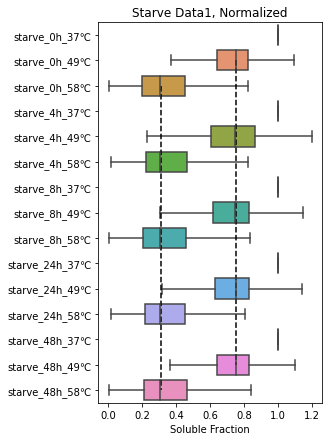

In [7]:
data_starve1 = pd.read_excel(data_dir+'starve_20220526.xlsx', usecols=[3, 6, 10, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])
data_starve1.columns = ['Accession', 'Contaminant', 'PSMs', 'starve_0h_37℃', 'starve_0h_49℃', 'starve_0h_58℃', 'starve_4h_37℃', 'starve_4h_49℃', 'starve_4h_58℃', 
                      'starve_8h_37℃', 'starve_8h_49℃', 'starve_8h_58℃', 'starve_24h_37℃', 'starve_24h_49℃', 'starve_24h_58℃', 'starve_48h_37℃', 'starve_48h_49℃', 'starve_48h_58℃']
data_starve1 = data_starve1[(data_starve1['Contaminant']==False) & (np.sum(data_starve1.isna(), axis=1)==0)].reset_index(drop=True)
del data_starve1['Contaminant']
print('Data 1 初始蛋白量：{}'.format(len(data_starve1)))

for i in range(5):
    data_starve1.iloc[:,-3*i-1] = data_starve1.iloc[:,-3*i-1] / data_starve1.iloc[:,-3*i-3]
    data_starve1.iloc[:,-3*i-2] = data_starve1.iloc[:,-3*i-2] / data_starve1.iloc[:,-3*i-3]
    data_starve1.iloc[:,-3*i-3] = data_starve1.iloc[:,-3*i-3] / data_starve1.iloc[:,-3*i-3]
    
m_49 = np.median(data_starve1.iloc[:,[3*i+3 for i in range(5)]], axis=0)
m_58 = np.median(data_starve1.iloc[:,[3*i+4 for i in range(5)]], axis=0)
m_49_m = np.median(m_49)
m_58_m = np.median(m_58)

# Data normalization
for i in range(5):
    data_starve1.iloc[:,[3*i+3]] = data_starve1.iloc[:,[3*i+3]] / m_49[i] * m_49_m
    data_starve1.iloc[:,[3*i+4]] = data_starve1.iloc[:,[3*i+4]] / m_58[i] * m_58_m
    # or +-
    # data_starve1.iloc[:,[3*i+3]] = data_starve1.iloc[:,[3*i+3]] - m_49[i] + m_49_m
    # data_starve1.iloc[:,[3*i+4]] = data_starve1.iloc[:,[3*i+4]] - m_58[i] + m_58_m
    
# Data filtering
data_starve1 = data_starve1[(data_starve1['starve_0h_49℃']<1.2)&(data_starve1['starve_0h_58℃']<1.2)&
                            (data_starve1['starve_4h_49℃']<1.2)&(data_starve1['starve_4h_58℃']<1.2)&
                            (data_starve1['starve_8h_49℃']<1.2)&(data_starve1['starve_8h_58℃']<1.2)&
                            (data_starve1['starve_24h_49℃']<1.2)&(data_starve1['starve_24h_58℃']<1.2)&
                            (data_starve1['starve_48h_49℃']<1.2)&(data_starve1['starve_48h_58℃']<1.2)].reset_index(drop=True)
print('Data 1 筛选后蛋白量：{}'.format(len(data_starve1)))
    
plt.figure(figsize=(4,7))
sns.boxplot(data=data_starve1.iloc[:,2:], showfliers=False, orient='h')
plt.yticks(list(range(0,15,1)), list(data_starve1.columns)[2:])
plt.xlabel('Soluble Fraction')
plt.title('Starve Data1, Normalized', fontsize=12)
plt.plot([m_49_m,m_49_m], [1,13], '--', color='black')
plt.plot([m_58_m,m_58_m], [2,14], '--', color='black')

Data 2 初始蛋白量：6627
Data 2 筛选后蛋白量：6402


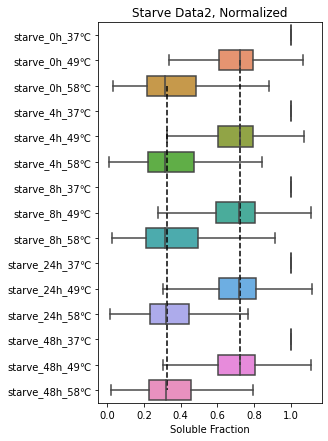

In [8]:
data_starve2 = pd.read_excel(data_dir+'starve_20220627.xlsx', usecols=[3, 6, 10, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])
data_starve2.columns = ['Accession', 'Contaminant', 'PSMs', 'starve_0h_37℃', 'starve_0h_49℃', 'starve_0h_58℃', 'starve_4h_37℃', 'starve_4h_49℃', 'starve_4h_58℃', 
                      'starve_8h_37℃', 'starve_8h_49℃', 'starve_8h_58℃', 'starve_24h_37℃', 'starve_24h_49℃', 'starve_24h_58℃', 'starve_48h_37℃', 'starve_48h_49℃', 'starve_48h_58℃']
data_starve2 = data_starve2[(data_starve2['Contaminant']==False) & (np.sum(data_starve2.isna(), axis=1)==0)].reset_index(drop=True)
del data_starve2['Contaminant']
print('Data 2 初始蛋白量：{}'.format(len(data_starve2)))

for i in range(5):
    data_starve2.iloc[:,-3*i-1] = data_starve2.iloc[:,-3*i-1] / data_starve2.iloc[:,-3*i-3]
    data_starve2.iloc[:,-3*i-2] = data_starve2.iloc[:,-3*i-2] / data_starve2.iloc[:,-3*i-3]
    data_starve2.iloc[:,-3*i-3] = data_starve2.iloc[:,-3*i-3] / data_starve2.iloc[:,-3*i-3]
    
m_49 = np.median(data_starve2.iloc[:,[3*i+3 for i in range(5)]], axis=0)
m_58 = np.median(data_starve2.iloc[:,[3*i+4 for i in range(5)]], axis=0)
m_49_m = np.median(m_49)
m_58_m = np.median(m_58)

for i in range(5):
    data_starve2.iloc[:,[3*i+3]] = data_starve2.iloc[:,[3*i+3]] / m_49[i] * m_49_m
    data_starve2.iloc[:,[3*i+4]] = data_starve2.iloc[:,[3*i+4]] / m_58[i] * m_58_m
    # or +-
    # data_starve2.iloc[:,[3*i+3]] = data_starve2.iloc[:,[3*i+3]] - m_49[i] + m_49_m
    # data_starve2.iloc[:,[3*i+4]] = data_starve2.iloc[:,[3*i+4]] - m_58[i] + m_58_m

data_starve2 = data_starve2[(data_starve2['starve_0h_49℃']<1.2)&(data_starve2['starve_0h_58℃']<1.2)&
                            (data_starve2['starve_4h_49℃']<1.2)&(data_starve2['starve_4h_58℃']<1.2)&
                            (data_starve2['starve_8h_49℃']<1.2)&(data_starve2['starve_8h_58℃']<1.2)&
                            (data_starve2['starve_24h_49℃']<1.2)&(data_starve2['starve_24h_58℃']<1.2)&
                            (data_starve2['starve_48h_49℃']<1.2)&(data_starve2['starve_48h_58℃']<1.2)].reset_index(drop=True)

print('Data 2 筛选后蛋白量：{}'.format(len(data_starve2)))

plt.figure(figsize=(4,7))
sns.boxplot(data=data_starve2.iloc[:,2:], showfliers=False, orient='h')
plt.yticks(list(range(0,15,1)), list(data_starve2.columns)[2:])
plt.xlabel('Soluble Fraction')
plt.title('Starve Data2, Normalized', fontsize=12)
plt.plot([m_49_m,m_49_m], [1,13], '--', color='black')
plt.plot([m_58_m,m_58_m], [2,14], '--', color='black')

# plt.savefig('./plot/starve v1v2v3/Boxplot_data2_norm.jpg', dpi=600, bbox_inches='tight')

Data 3 初始蛋白量：6411
Data 3 筛选后蛋白量：5920


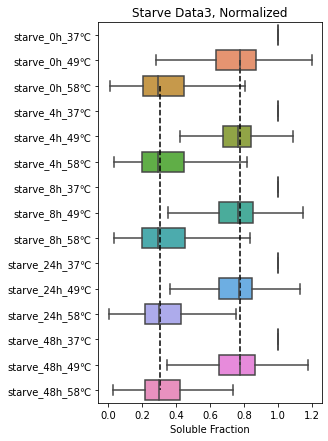

In [9]:
data_starve3 = pd.read_excel(data_dir+'starve_20220629.xlsx', usecols=[3, 6, 10, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])
data_starve3.columns = ['Accession', 'Contaminant', 'PSMs', 'starve_0h_37℃', 'starve_0h_49℃', 'starve_0h_58℃', 'starve_4h_37℃', 'starve_4h_49℃', 'starve_4h_58℃', 
                      'starve_8h_37℃', 'starve_8h_49℃', 'starve_8h_58℃', 'starve_24h_37℃', 'starve_24h_49℃', 'starve_24h_58℃', 'starve_48h_37℃', 'starve_48h_49℃', 'starve_48h_58℃']
data_starve3 = data_starve3[(data_starve3['Contaminant']==False) & (np.sum(data_starve3.isna(), axis=1)==0)].reset_index(drop=True)
del data_starve3['Contaminant']
print('Data 3 初始蛋白量：{}'.format(len(data_starve3)))

for i in range(5):
    data_starve3.iloc[:,-3*i-1] = data_starve3.iloc[:,-3*i-1] / data_starve3.iloc[:,-3*i-3]
    data_starve3.iloc[:,-3*i-2] = data_starve3.iloc[:,-3*i-2] / data_starve3.iloc[:,-3*i-3]
    data_starve3.iloc[:,-3*i-3] = data_starve3.iloc[:,-3*i-3] / data_starve3.iloc[:,-3*i-3]
    
m_49 = np.median(data_starve3.iloc[:,[3*i+3 for i in range(5)]], axis=0)
m_58 = np.median(data_starve3.iloc[:,[3*i+4 for i in range(5)]], axis=0)
m_49_m = np.median(m_49)
m_58_m = np.median(m_58)

for i in range(5):
    data_starve3.iloc[:,[3*i+3]] = data_starve3.iloc[:,[3*i+3]] / m_49[i] * m_49_m
    data_starve3.iloc[:,[3*i+4]] = data_starve3.iloc[:,[3*i+4]] / m_58[i] * m_58_m
    # or +-
    # data_starve3.iloc[:,[3*i+3]] = data_starve3.iloc[:,[3*i+3]] - m_49[i] + m_49_m
    # data_starve3.iloc[:,[3*i+4]] = data_starve3.iloc[:,[3*i+4]] - m_58[i] + m_58_m
    
data_starve3 = data_starve3[(data_starve3['starve_0h_49℃']<1.2)&(data_starve3['starve_0h_58℃']<1.2)&
                            (data_starve3['starve_4h_49℃']<1.2)&(data_starve3['starve_4h_58℃']<1.2)&
                            (data_starve3['starve_8h_49℃']<1.2)&(data_starve3['starve_8h_58℃']<1.2)&
                            (data_starve3['starve_24h_49℃']<1.2)&(data_starve3['starve_24h_58℃']<1.2)&
                            (data_starve3['starve_48h_49℃']<1.2)&(data_starve3['starve_48h_58℃']<1.2)].reset_index(drop=True)
    
print('Data 3 筛选后蛋白量：{}'.format(len(data_starve3)))
    
plt.figure(figsize=(4,7))
sns.boxplot(data=data_starve3.iloc[:,2:], showfliers=False, orient='h')
plt.yticks(list(range(0,15,1)), list(data_starve3.columns)[2:])
plt.xlabel('Soluble Fraction')
plt.title('Starve Data3, Normalized', fontsize=12)
plt.plot([m_49_m,m_49_m], [1,13], '--', color='black')
plt.plot([m_58_m,m_58_m], [2,14], '--', color='black')

# plt.savefig('./plot/starve v1v2v3/Boxplot_data3_norm.jpg', dpi=600, bbox_inches='tight')

In [10]:
# Data filtering: proteins identified in at least 2 data sets with at least 3 overall PSMs

list_union = list(data_starve1['Accession']) + list(data_starve2['Accession']) + list(data_starve3['Accession'])
count_set = set(list_union)
count_dict = {}
for i in count_set:
    count_dict[i] =  list_union.count(i)
    
count_df = pd.DataFrame(list(count_dict.items()))
count_df.columns = ['Accession', 'Sum of Data']
print('简单并集蛋白量：{}'.format(len(count_df)))

count_df = count_df[count_df['Sum of Data']>1].reset_index(drop=True)
print('至少两个Data蛋白量：{}'.format(len(count_df)))

data1_union = pd.merge(count_df, data_starve1.iloc[:,[0,1]], on='Accession', how='outer')
data1_union = data1_union[data1_union['Sum of Data'].notna()]
data1_union = data1_union.replace(to_replace=np.nan, value=0)

data2_union = pd.merge(count_df, data_starve2.iloc[:,[0,1]], on='Accession', how='outer')
data2_union = data2_union[data2_union['Sum of Data'].notna()]
data2_union = data2_union.replace(to_replace=np.nan, value=0)

data3_union = pd.merge(count_df, data_starve3.iloc[:,[0,1]], on='Accession', how='outer')
data3_union = data3_union[data3_union['Sum of Data'].notna()]
data3_union = data3_union.replace(to_replace=np.nan, value=0)

count_df['Sum of PSMs'] = data1_union['PSMs'] + data2_union['PSMs']  + data3_union['PSMs']
count_df = count_df[count_df['Sum of PSMs']>2].reset_index(drop=True)

简单并集蛋白量：8059
至少两个Data蛋白量：5973


In [17]:
# add by wangjun
count_df

,Accession,Sum of Data,Sum of PSMs
0,R4GMU7,2,3.0
1,B4DLR8,3,47.0
2,Q9ULH0,3,277.0
3,Q8IWL3,2,6.0
4,P54819,3,269.0
...,...,...,...
5808,P20339,3,120.0
5809,Q13232,3,103.0
5810,A0A2R8Y6L5,2,8.0
5811,Q96MH2,3,13.0


In [18]:
# Generate union data

data_starve1_union = pd.merge(count_df, data_starve1, on='Accession', how='outer')
data_starve1_union = data_starve1_union[data_starve1_union['Sum of Data'].notna()]
data_starve1_union = data_starve1_union.replace(to_replace=np.nan, value=0)

data_starve2_union = pd.merge(count_df, data_starve2, on='Accession', how='outer')
data_starve2_union = data_starve2_union[data_starve2_union['Sum of Data'].notna()]
data_starve2_union = data_starve2_union.replace(to_replace=np.nan, value=0)

data_starve3_union = pd.merge(count_df, data_starve3, on='Accession', how='outer')
data_starve3_union = data_starve3_union[data_starve3_union['Sum of Data'].notna()]
data_starve3_union = data_starve3_union.replace(to_replace=np.nan, value=0)

data_union = copy.copy(count_df)

for i in range(15):
    data_union.insert(loc=i+3, column=data_starve1_union.columns[i+4], 
                      value = ((data_starve1_union.iloc[:,i+4]*data_starve1_union['PSMs'] + 
                                data_starve2_union.iloc[:,i+4]*data_starve2_union['PSMs'] + 
                                data_starve3_union.iloc[:,i+4]*data_starve3_union['PSMs']) / data_union['Sum of PSMs']))
    
data_union_0h = data_union.iloc[:,[0,3,4,5]]
data_union_4h = data_union.iloc[:,[0,6,7,8]]
data_union_8h = data_union.iloc[:,[0,9,10,11]]
data_union_24h = data_union.iloc[:,[0,12,13,14]]
data_union_48h = data_union.iloc[:,[0,15,16,17]]

In [25]:
# add by wangjun
data_union

,Accession,Sum of Data,Sum of PSMs,starve_0h_37℃,starve_0h_49℃,starve_0h_58℃,starve_4h_37℃,starve_4h_49℃,starve_4h_58℃,starve_8h_37℃,starve_8h_49℃,starve_8h_58℃,starve_24h_37℃,starve_24h_49℃,starve_24h_58℃,starve_48h_37℃,starve_48h_49℃,starve_48h_58℃
0,R4GMU7,2,3.0,1.0,0.705200,0.365929,1.0,0.936513,0.587983,1.0,0.816301,0.379257,1.0,0.861015,0.391098,1.0,0.574993,0.411197
1,B4DLR8,3,47.0,1.0,0.643735,0.186588,1.0,0.426649,0.198031,1.0,0.492953,0.252138,1.0,0.508590,0.246808,1.0,0.628845,0.407693
2,Q9ULH0,3,277.0,1.0,0.810223,0.298765,1.0,0.735769,0.278711,1.0,0.744282,0.273015,1.0,0.731418,0.289251,1.0,0.694959,0.322143
3,Q8IWL3,2,6.0,1.0,0.635398,0.319557,1.0,0.619473,0.278748,1.0,0.714579,0.300950,1.0,0.674394,0.250128,1.0,0.672732,0.301935
4,P54819,3,269.0,1.0,0.856269,0.497765,1.0,0.856321,0.444233,1.0,0.865461,0.459821,1.0,0.855867,0.433130,1.0,0.909835,0.537743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5808,P20339,3,120.0,1.0,0.631795,0.229889,1.0,0.508238,0.140456,1.0,0.611485,0.150143,1.0,0.503731,0.157498,1.0,0.707461,0.268603
5809,Q13232,3,103.0,1.0,0.825980,0.620605,1.0,0.899894,0.698587,1.0,0.862373,0.665182,1.0,0.876000,0.645058,1.0,0.865670,0.585085
5810,A0A2R8Y6L5,2,8.0,1.0,0.778993,0.228532,1.0,0.712522,0.283007,1.0,0.725415,0.262531,1.0,0.703969,0.329283,1.0,0.680495,0.267094
5811,Q96MH2,3,13.0,1.0,0.831198,0.510918,1.0,0.862699,0.532488,1.0,0.869289,0.566708,1.0,0.803375,0.505731,1.0,0.811265,0.543788


<AxesSubplot:>

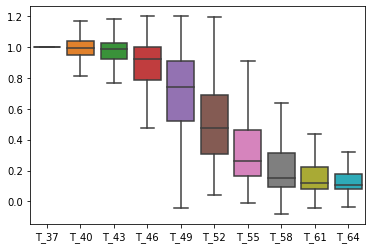

In [5]:
# Using boxplot to show the trend of data

sns.boxplot(data = TPCA_table7, showfliers=False)

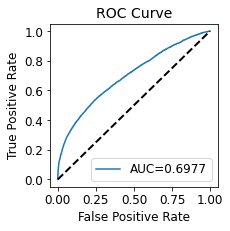

In [6]:
# Using ROC curve to evaluate the prediction

roc_plot(TPCA_table7, pair_table1)

In [8]:
# Calculate TPCA signatures of complexes by sampling

%time table7_random_sample_4t, table7_sig_sample_4t = complex_signature_sample(TPCA_table7_4t, corum)

Wall time: 13min 50s


In [17]:
# Calculate TPCA signatures of complexes by Beta distribution fitting

%time table7_random_beta_4t, table7_sig_beta_4t = complex_signature_beta(TPCA_table7_4t, corum)

Wall time: 1min 5s


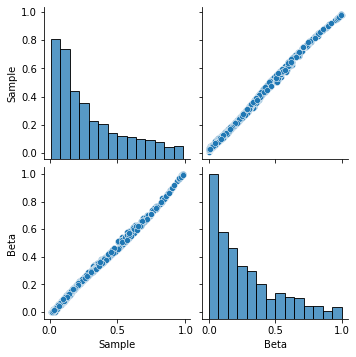

In [43]:
sig_result = pd.DataFrame({'Sample':table7_sig_sample_4t['TPCA_Sig_P-value'], 'Beta':table7_sig_beta_4t['TPCA_Sig_P-value']})
sig_result = sig_result[np.sum(sig_result==0, axis=1)==0].reset_index(drop=True)
sns.pairplot(data=sig_result)

In [25]:
# Calculate TPCA dynamic modulation signatures of complexes by sampling and absolute distance

%time MTX_dynamic_absolute_random_4t, MTX_dynamic_absolute_sample_4t = dynamic_complex_absolute_sample(TPCA_DMSO_4t, TPCA_MTX_4t, corum)

Wall time: 19min 48s


In [26]:
# Calculate TPCA dynamic modulation signatures of complexes by sampling and relative distance

%time MTX_dynamic_relative_random_4t, MTX_dynamic_relative_sample_4t = dynamic_complex_relative_sample(TPCA_DMSO_4t, TPCA_MTX_4t, corum)

Wall time: 20min 24s


In [27]:
# Calculate TPCA dynamic modulation signatures of complexes by Beta distribution fitting and absolute distance

%time MTX_dynamic_absolute_beta_4t = dynamic_complex_absolute_beta(TPCA_DMSO_4t, TPCA_MTX_4t, corum)

Wall time: 1min 34s


In [28]:
# Calculate TPCA dynamic modulation signatures of complexes by Beta distribution fitting and relative distance

%time MTX_dynamic_relative_beta_4t = dynamic_complex_relative_beta(TPCA_DMSO_4t, TPCA_MTX_4t, corum)

Wall time: 1min 33s


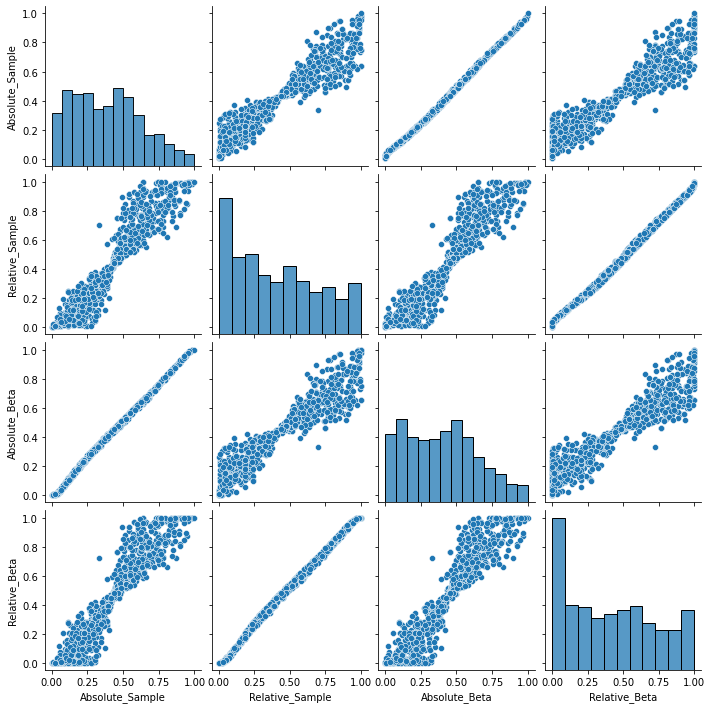

In [39]:
dynamic_result = pd.DataFrame({'Absolute_Sample':MTX_dynamic_absolute_sample_4t['Dynamic_P'], 'Relative_Sample':MTX_dynamic_relative_sample_4t['Dynamic_P'], 
                               'Absolute_Beta':MTX_dynamic_absolute_beta_4t['Dynamic_P'], 'Relative_Beta':MTX_dynamic_relative_beta_4t['Dynamic_P']})
sns.pairplot(data=dynamic_result)